Only use the following cell if you need to install these packages. This was written for Google colab. The two cells following will import some essential packages and the data.

In [1]:
!pip install sentencepiece
import nltk
nltk.download('wordnet')

     |████████████████████████████████| 1.0MB 2.8MB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import tokenization
from nltk.stem import WordNetLemmatizer
import re

data = pd.read_csv('irma_power_tweets.csv')

Let's define some functions for assessing the results later.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [10,10]

def plot_confusion_matrix(cm, labels: list, normalize=False, title='Confusion Matrix', cmap=plt.cm.Oranges):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title,size=24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, size=14)
    plt.yticks(tick_marks, labels, size=14)
    
    fmt = '.2f' if normalize else 'd' # format of decimal precision to display
    thresh = cm.max()/2 # threshold to change color of text depending on color of cell
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # realistically, cm.shape[0] = cm.shape[1] = len(labels)
        plt.text(j, i, format(cm[i,j], fmt), fontsize=20, # i,j rev bc of diff btwn matrix and list of lists indexing
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black') # if the cell color is too dark, make the text white
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', size=16)
    plt.xlabel('Predicted label', size=16)

#rerun numbers wuth Ytrain and rf.predict(Xtrain)
def scoring(Ytrain, Ytrain_pred, Ytest, Ypred, print_score=True):
    

    acc_train = accuracy_score(Ytrain, Ytrain_pred)
    prec_train = precision_score(Ytrain, Ytrain_pred)
    rec_train = recall_score(Ytrain, Ytrain_pred)
    f1_train = f1_score(Ytrain, Ytrain_pred)
    
    acc = accuracy_score(Ytest, Ypred)
    prec = precision_score(Ytest, Ypred)
    rec = recall_score(Ytest, Ypred)
    f1 = f1_score(Ytest, Ypred)

    scores = {'accuracy': acc,
              'precision': prec,
             'recall': rec,
             'f1 score': f1}

    scores_train = {'accuracy': acc_train,
              'precision': prec_train,
             'recall': rec_train,
             'f1 score': f1_train}
             
    if print_score:
        print('Ytrain vs Ytrain_pred')
        for metric in scores_train.keys():
            print(f'{metric}: {scores_train[metric]:.2f}')
        
        print('Ytest vs Ypred')
        for metric in scores.keys():
            print(f'{metric}: {scores[metric]:.2f}')

    return scores_train, scores

The following cell contains the preprocessing code. We define the neighborhood generating function. We also define a lemmatizer function that is used as part of the neighborhood generation.

In [0]:
tokenizer = tokenization.BasicTokenizer()

def lemmatize(x):
  lemmatizer = WordNetLemmatizer()
  return lemmatizer.lemmatize(lemmatizer.lemmatize(x,pos='v'))

def neighborhood_generator(text,kwd,r):
    parse_seq = r'[-_+<=>\[\]{}`&;\/()#!@,.\n?]|\x80|\:\/\/.*$'
    split_tokens = text.lower().split()
    kwd_idx = 0

    def tok_process(tok): #remove special chars, apply basic BERT tokenizer, and lemmatize
        parse_tok = re.sub(parse_seq, ' ', tok)
        tok_tokens = tokenizer.tokenize(parse_tok) #tokens of the token!
        tok_lemmatized_tokens = [lemmatize(tok_tok) for tok_tok in tok_tokens]
        return tok_lemmatized_tokens

    if kwd in split_tokens: #see if we can get away without going through the text processing
        kwd_idx = [idx for idx in range(len(split_tokens)) if split_tokens[idx]==kwd][0]
    else:
        for idx in range(len(split_tokens)):
            tok = split_tokens[idx]
            tok_lemmatized_tokens = tok_process(tok)
            if kwd in tok_lemmatized_tokens:
                kwd_idx = idx
                break
                
    # found the kwd, now find non-stopwords/length 1 words to form neighborhood
    # idea: divide the split tokens into two groups: the tokens before kwd, and the tokens after kwd
    # starting from the kwd, iterate thru the tokens backwards (before kwd list) or forwards (after kwd list)
    # check if the word if a stop word or a special char
    # if it isn't, have a counter increase by one. once that counter == radius, save the idx of that word and break
    # then slice the string like usual

    neighborhood_radius = r
    before_kwd = split_tokens[:kwd_idx]
    after_kwd = split_tokens[kwd_idx+1:]

    before_idx = [idx for idx in range(kwd_idx)][::-1]
    after_idx = [idx for idx in range(kwd_idx+1,len(split_tokens))]
    start_tok_idx = 0 #if search extends beyond startin index, use the first token
    end_tok_idx = len(split_tokens) #if search extends beyond last index, use the last index
    before_sig_toks = 0
    after_sig_toks = 0

    for idx in before_idx:
        tok = split_tokens[idx]
        tok_lemmatized_tokens = tok_process(tok)
        if len(tok_lemmatized_tokens) > 0: # significant token
            before_sig_toks += 1
            if before_sig_toks == neighborhood_radius:
                start_tok_idx = idx
                break
    
    for idx in after_idx:
        tok = split_tokens[idx]
        tok_lemmatized_tokens = tok_process(tok)
        if len(tok_lemmatized_tokens) > 0:
            after_sig_toks += 1
            if after_sig_toks == neighborhood_radius:
                end_tok_idx = idx
                break

    neighborhood = split_tokens[start_tok_idx:end_tok_idx+1]
    neighborhood = ' '.join(neighborhood)
    
    return neighborhood

The following cell defines a routine that goes through the whole process cleaning the data, generating neighborhoods, and using cross validation to find an optimal random forest model. The given inputs are the data (as a whole dataframe), the neighborhood radius, the maximum number of features to use in the count vectorizer, the size of n-grams used in the count vectorizer, a count of incorrectly labelled tweets (used for hyperparameter tuning -- see the cell after), and a yes/no to return the best model, which will also output the results of that model. 

In [0]:
from sklearn.model_selection import RandomizedSearchCV

def rf_neighborhood_method(data, r, max_ft, ngram_size, min_wrong=1000, return_model=False): # set return_model=True to have the fxn return the best RF model 

    town = pd.DataFrame(columns=['text']) # a town is a collection of neighborhoods
    neighborhood_vals = []

    for idx in data.index:
        row = data.iloc[idx]
        text = row.text
        kwd = row.kwd
        new_row = neighborhood_generator(text,kwd,r)
        neighborhood_vals.append(new_row)
    town.text = neighborhood_vals

    cv = CountVectorizer(list(town.text.values),
                        max_features=max_ft,
                        ngram_range=ngram_size,
                        min_df=10,
                        stop_words='english')
    
    count_vect = cv.fit_transform(list(town.text.values))

    table = count_vect.toarray() #reminder: this lists each twt as a vect
    features = cv.get_feature_names()
    df = pd.DataFrame(table, columns=features)
    df['topic_related'] = data.topic_related

    # Define a grid of parameters for CV
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)]
    max_features = ['auto', 'sqrt'] 
    max_depth = [int(x) for x in np.linspace(0, max_ft, num = 5) if x>0]
    max_depth.append(None)
    min_samples_split = [2, 3, 4]
    min_samples_leaf = [1, 2, 3]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[features],
                                                    df['topic_related'],
                                                    test_size=0.2,
                                                    random_state=25
                                                    )

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf,
                                param_distributions=random_grid,
                                n_iter=100,
                                cv=5,
                                verbose=1,
                                random_state=25,
                                n_jobs=-1)
    rf_random.fit(Xtrain, Ytrain)
    rf_best = rf_random.best_estimator_

    Ytrain_pred = rf_best.predict(Xtrain)
    Ypred = rf_best.predict(Xtest)
    train_scores_dict, scores_dict = scoring(Ytrain, Ytrain_pred, Ytest, Ypred, print_score=False)
    train_scores = np.array(list(train_scores_dict.values()))
    scores = np.array(list(scores_dict.values()))
    
    if return_model:
        scoring(Ytrain, Ytrain_pred, Ytest, Ypred, print_score=True)
        cm = confusion_matrix(Ytest, Ypred)
        cm_labels = ['Not topic-related', 'Topic-related']
        plot_confusion_matrix(cm, cm_labels, title='Random Forest Confusion Matrix')
        return rf_best
    else:
        train_test_err = np.sum(np.abs(train_scores-scores)) # <= 0.1:  no overfitting
        wrong_count = np.sum(Ytest!=Ypred)
        if wrong_count <= min_wrong and train_test_err <= 0.1:
            min_params = {'r': r,
                        'max_ft': max_ft,
                        'ngram_size': ngram_size}
            return (wrong_count, min_params) #save results as a list of 2-tuples
        else:
            return 'nothing new'

The following cell is for tuning parameters of the count vectorizer, namely the number of count vectorizer features and size of n-grams. r_vals can be set to a single radius value to search for the best parameters of a particular radius. With a little bit of work, this code cell and the previous cell can be rewritten so that r_vals can be a list of radii and the output will be a list of optimal parameters for each radius. Otherwise I just run individual notebooks in parallel for each radius.

In [0]:
r_vals = [1,2,3]
max_ft_vals = [100, 150, 200]
ngram_size_vals = [(1,1), (1,2), (2,2), (1,3)]

results = []
min_wrong = 1000
for r in r_vals:
    for max_ft in max_ft_vals:
        for ngram_size in ngram_size_vals:
            new_results = rf_neighborhood_method(data, r, max_ft, ngram_size, min_wrong)
            params = [r, max_ft, ngram_size]
            params = ' '.join([str(x) for x in params])
            if new_results == 'nothing new':
                print('nothing new: ' + params)
            else:
                results.append(new_results)
                min_wrong = new_results[0]
                print('something new: ' + params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.0min finished


something new: 5 100 (1, 1)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min finished


nothing new: 5 100 (1, 2)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished


nothing new: 5 100 (2, 2)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min finished


nothing new: 5 100 (1, 3)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished


something new: 5 150 (1, 1)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


nothing new: 5 150 (1, 2)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished


nothing new: 5 150 (2, 2)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


nothing new: 5 150 (1, 3)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished


nothing new: 5 200 (1, 1)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


nothing new: 5 200 (1, 2)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished


nothing new: 5 200 (2, 2)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


nothing new: 5 200 (1, 3)


The last element in ```results``` should have the optimal parameters, which you can then run a cross validation for the random forest: 



Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished


Ytrain vs Ytrain_pred
accuracy: 0.88
precision: 0.86
recall: 0.99
f1 score: 0.92
Ytest vs Ypred
accuracy: 0.85
precision: 0.84
recall: 0.97
f1 score: 0.90


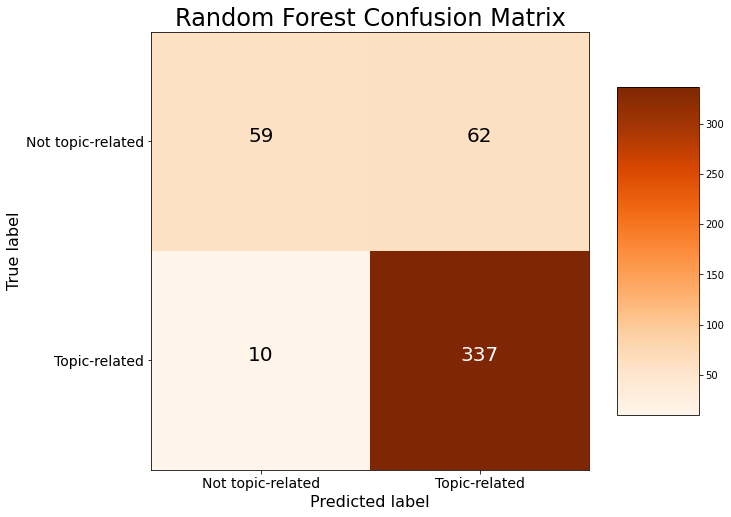

In [0]:
rf = rf_neighborhood_method(data, max_ft=150, ngram_size=(1,1), r=5, return_model=True)